In [18]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import datetime
import fermi.tipsh as tipsh
from fermi.skymap import imshow_mollweide, imshow_carree, imshow_spherified_carree, imshow, animate_carree
import math
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mmappickle.dict import mmapdict
import numpy
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.stats import poisson, skellam

import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri

numpy2ri.activate()

stats = importr("stats")
skel = importr("skellam")

rc('animation', html='jshtml')

In [34]:
J = 12
energies = ['100-200mev', '200-500mev', '500-1000mev', '1-2gev', '2-5gev', '5-10gev', '10-20gev', '20-50gev', '50-100gev', '100-200gev', '200-500gev', '500-1000gev']
fits_root = 'fits_files'
fwer = 'sidak'
alpha = 0.01
date = '2022-01-31'
v02_modified_results = {}
for energy in energies:
    filename = f"v02_modified_{date}_{energy}_{fwer}_{alpha}.mmdpickle"
    v02_modified_results[energy] = mmapdict(filename)

# Abstract
Pass 8 data from the Fermi LAT Instrument are analyzed using the TIPSH method (Kolaczyk and Dixon 1999) as a tool non-parametric hypothesis testing. Rather than "denoising" an image, TIPSH is used to detect significant differences in Haar wavelet coefficients when comparing the wavelet decompositions of the binned data and a model of expected counts over the same field-of-view. We show results using the most recent v07 background models and the v02 model employed for the discovery of the Fermi bubbles. We present analysis of the morphology and statistical significance of the residuals. In particular, we demonstrate to high significance that the morphology of the Fermi bubbles is remarkably constant over more than three decades in energy, exhibiting similar shape sharp edges and substructure within the south bubble.

# Motivation
A common problem in high energy astronomy is the detection and quantification of excess emission above an expected count background. Simple scenarios may be accomplished by maximum likelihood analysis of low-dimensional models, such as location and spectral analysis of isolated compact sources within a narrow field of view, given background emission from various extended sources and other known compact sources within the FOV. Such model fits will usually also provide information to aid in probabilistic reasoning about the results: how confident are we in the detection? How strong is our belief in particular hypothesis vs. alternatives, e.g. a single strong point source vs. multiple clustered weaker sources?

Model-fitting methods do not extend well to detection and analysis of extended sources with uncertain morphology. The problem becomes much higher dimensional (e.g. non-parametric or hyperparametric) with many local minima in the objective function (Poisson likelihood, in this case). Poisson likelihood is a global measure of "goodness of fit", providing no method for reasoning about the spatial variation in the difference between a candidate hypothesis and the data. For Fermi LAT data, a common method (see e.g. Dobler et al 2010, Su et al 2010) has been to take the difference between the binned photon data maps and the hypothetical count map and smooth the result with a fixed-width Gaussian. Such an approach is fine for qualitative "first-look" analysis, but is limiting in several respects:
* Photon shot noise is not additive. A Gaussian filter applied to an image corrupted by additive white (or other broad-spectrum) noise has a simple interpretation of filtering high frequencies. Such an interpretation does not apply in photon-limited images, and it is difficult to reason about the effect of filtering.
* Choice of a single filter kernel is limiting, and will tend to enhance structures around the filter cutoff and may suppress features a smaller scale.
* We have no practical way of quantitatively reasoning about the results. The convolution of Poisson variables (pixel intensities in the data and model) with a Gaussian kernal is not easily amenable to statistical analysis, and the signficance of the smoothed residuals between data and model are difficult to assess.

We demonstrate with example data which is extremely photon limited. The count map below is taken from Fermi data for mission times between ??? and ????.

Total photons: 2340


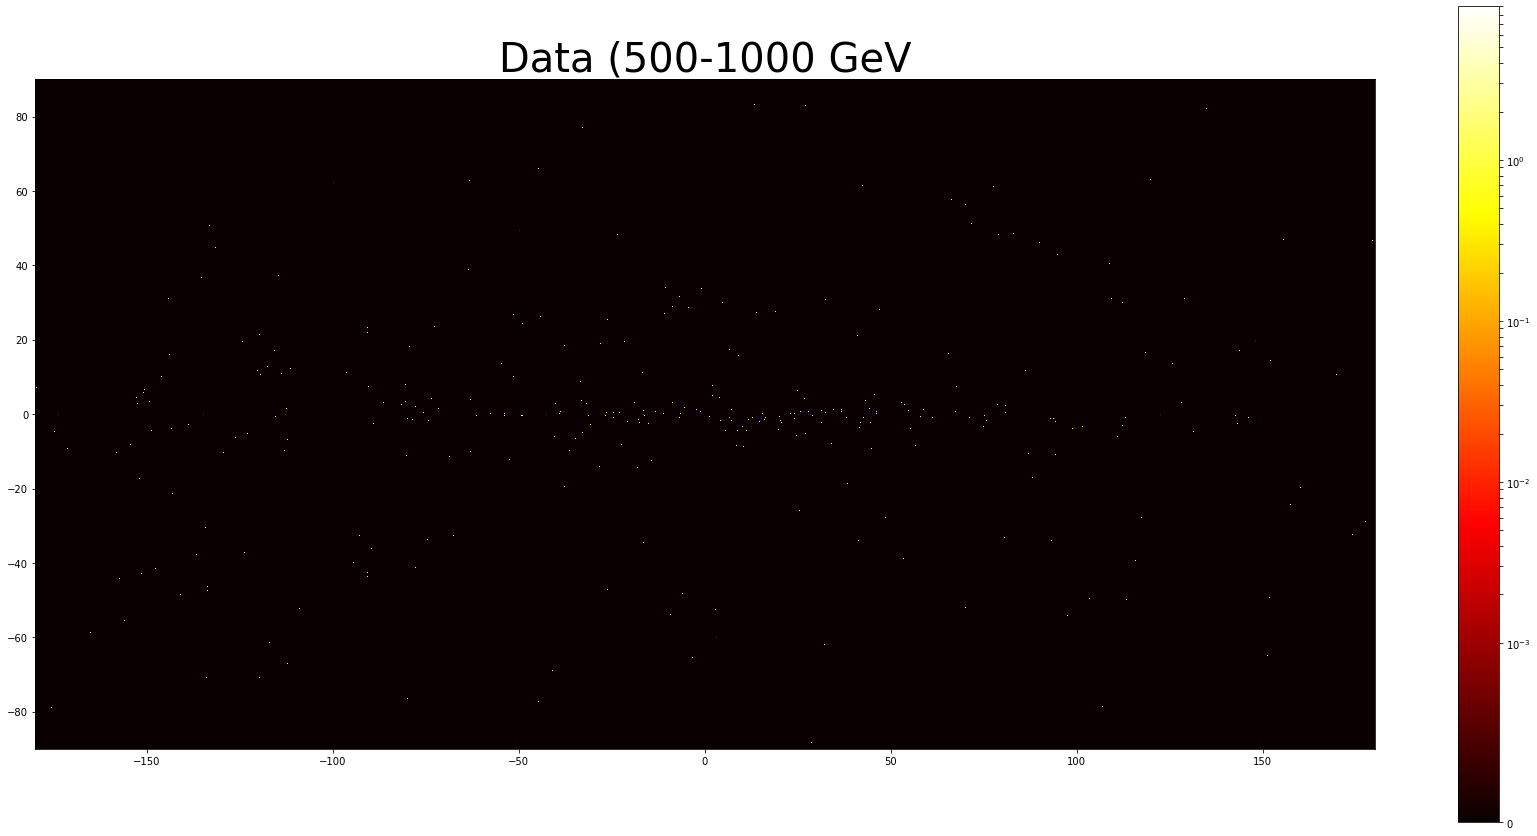

In [3]:
print('Total photons:', numpy.sum(v02_modified_results['500-1000gev']['count_data']))
imshow_carree(v02_modified_results['500-1000gev']['count_data'], plt.cm.hot, norm=colors.SymLogNorm(linthresh=1e-3), interpolation='none', title='Data (500-1000 GeV)')

Suppose then we wish to compare this count map against the hypothesis below, which is a combination of the galactic and isotropic diffuse models generated by the Fermi Space Science Center tools [ADD LINK] and the expected counts from sources in the 4th Fermi Source Catalog [ADD LINK]. Note that the galactic diffuse model is the v02 version and has been scaled to 30% of the level provided by the FSSC tools (these choices are discussed later in the notebook).

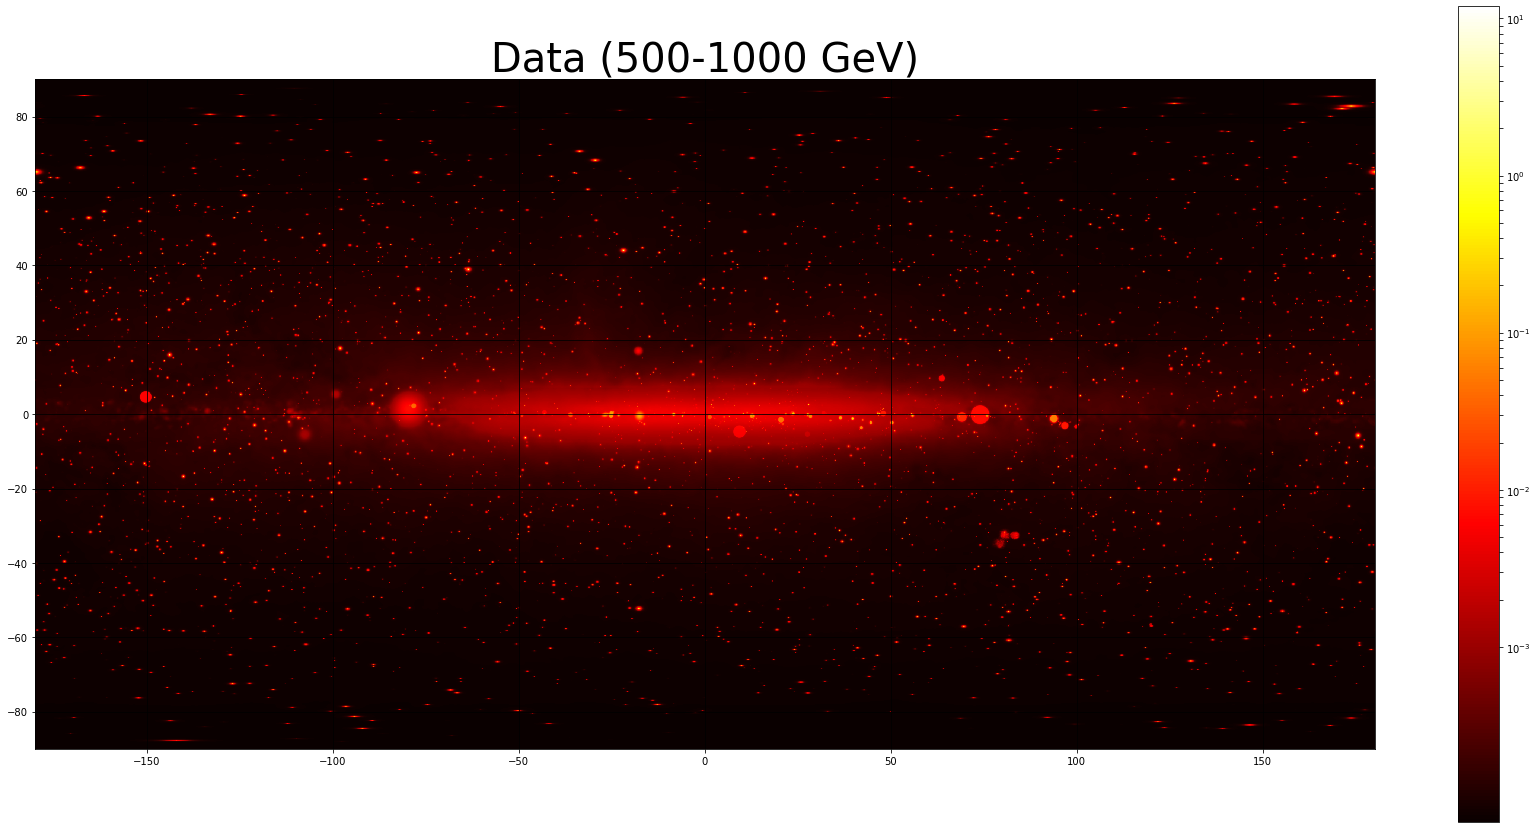

In [4]:
imshow_carree(v02_modified_results['500-1000gev']['total_model'], plt.cm.hot, norm=colors.SymLogNorm(linthresh=1e-3), interpolation='none', title='Data (500-1000 GeV)')

Following the usual procedure described above, we will blur the difference between these data and model count maps:

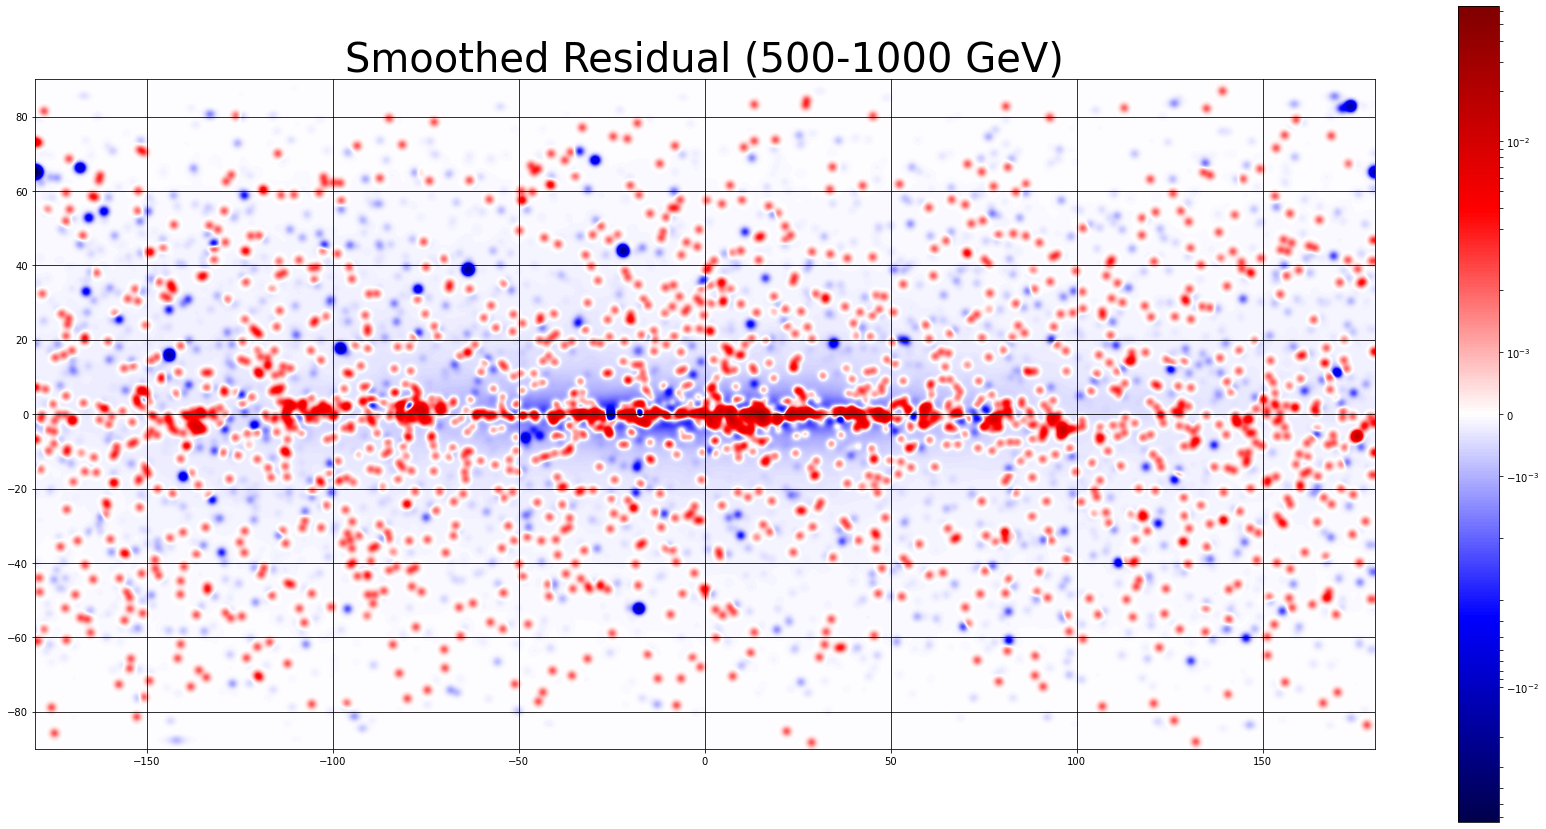

In [5]:
sigma = 8.45 # Sigma in pixels corresponding 2 degrees FWHM for 0.1 degree pixels
imshow_carree(gaussian_filter(v02_modified_results['500-1000gev']['count_data'] - v02_modified_results['500-1000gev']['total_model'], sigma), plt.cm.seismic, linthresh=3e-3, title='Smoothed Residual (500-1000 GeV)')

Clearly, any sort of interpretation here is challenging. Let's also look at the 5-10 GeV band, where we have much better photon statistics.

Total photons: 2012653


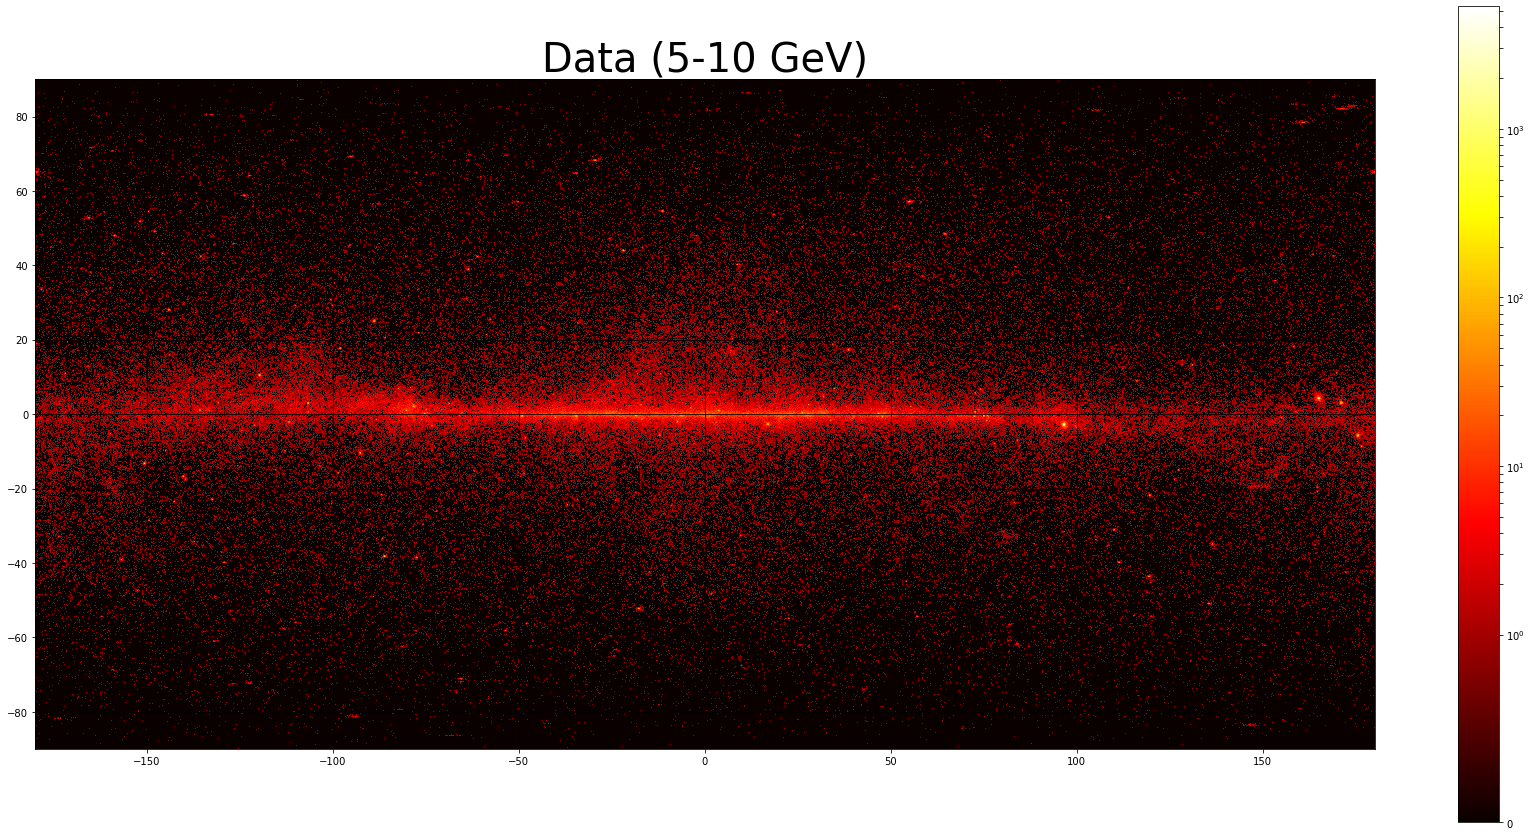

In [6]:
print('Total photons:', numpy.sum(v02_modified_results['5-10gev']['count_data']))
imshow_carree(v02_modified_results['5-10gev']['count_data'], plt.cm.hot, norm=colors.SymLogNorm(linthresh=1e-0), interpolation='none', title='Data (5-10 GeV)')

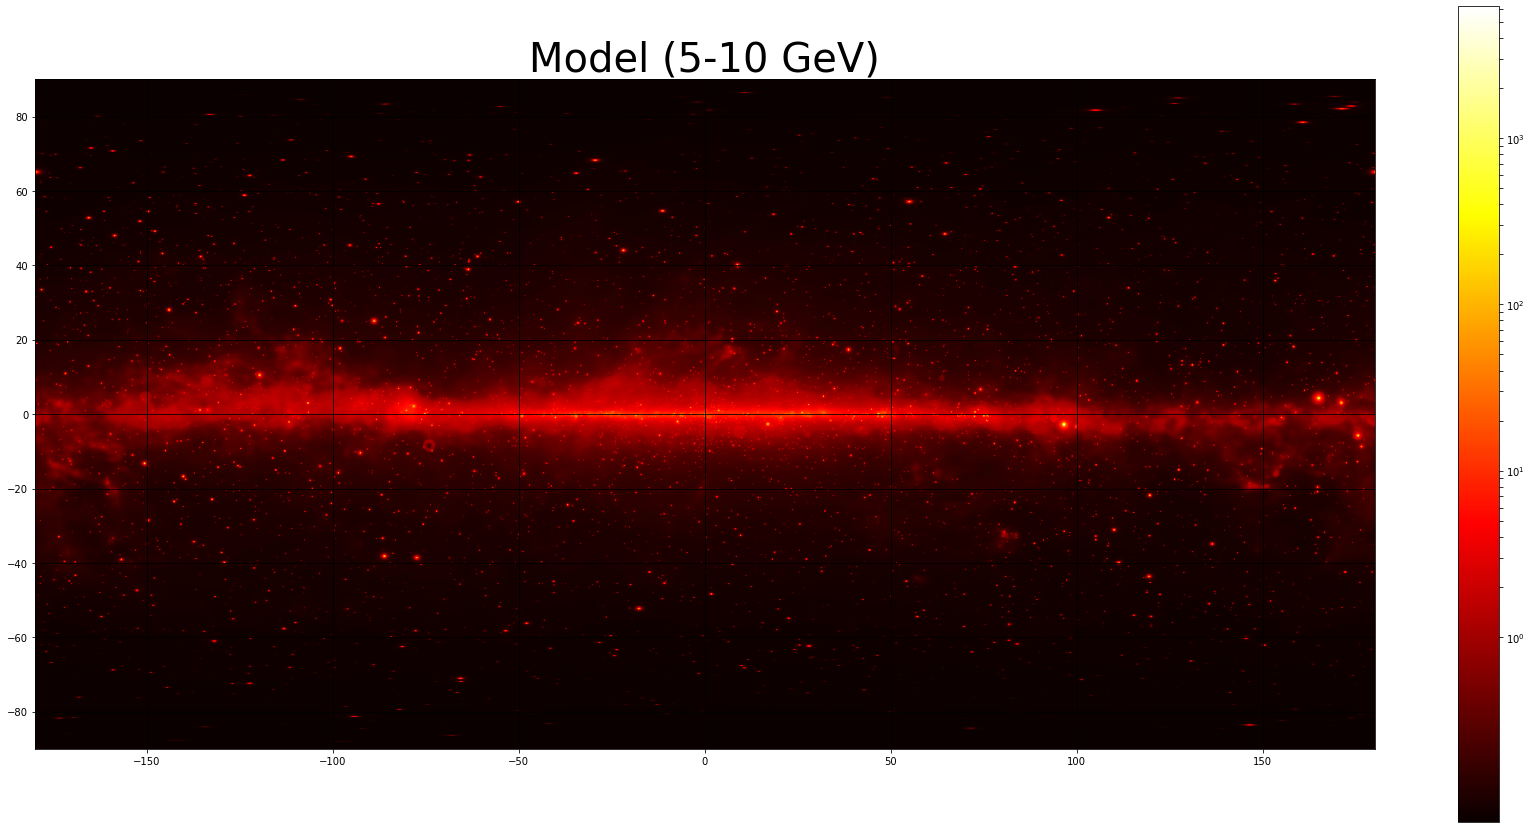

In [7]:
imshow_carree(v02_modified_results['5-10gev']['total_model'], plt.cm.hot, norm=colors.SymLogNorm(linthresh=1e-0), interpolation='none', title='Model (5-10 GeV)')

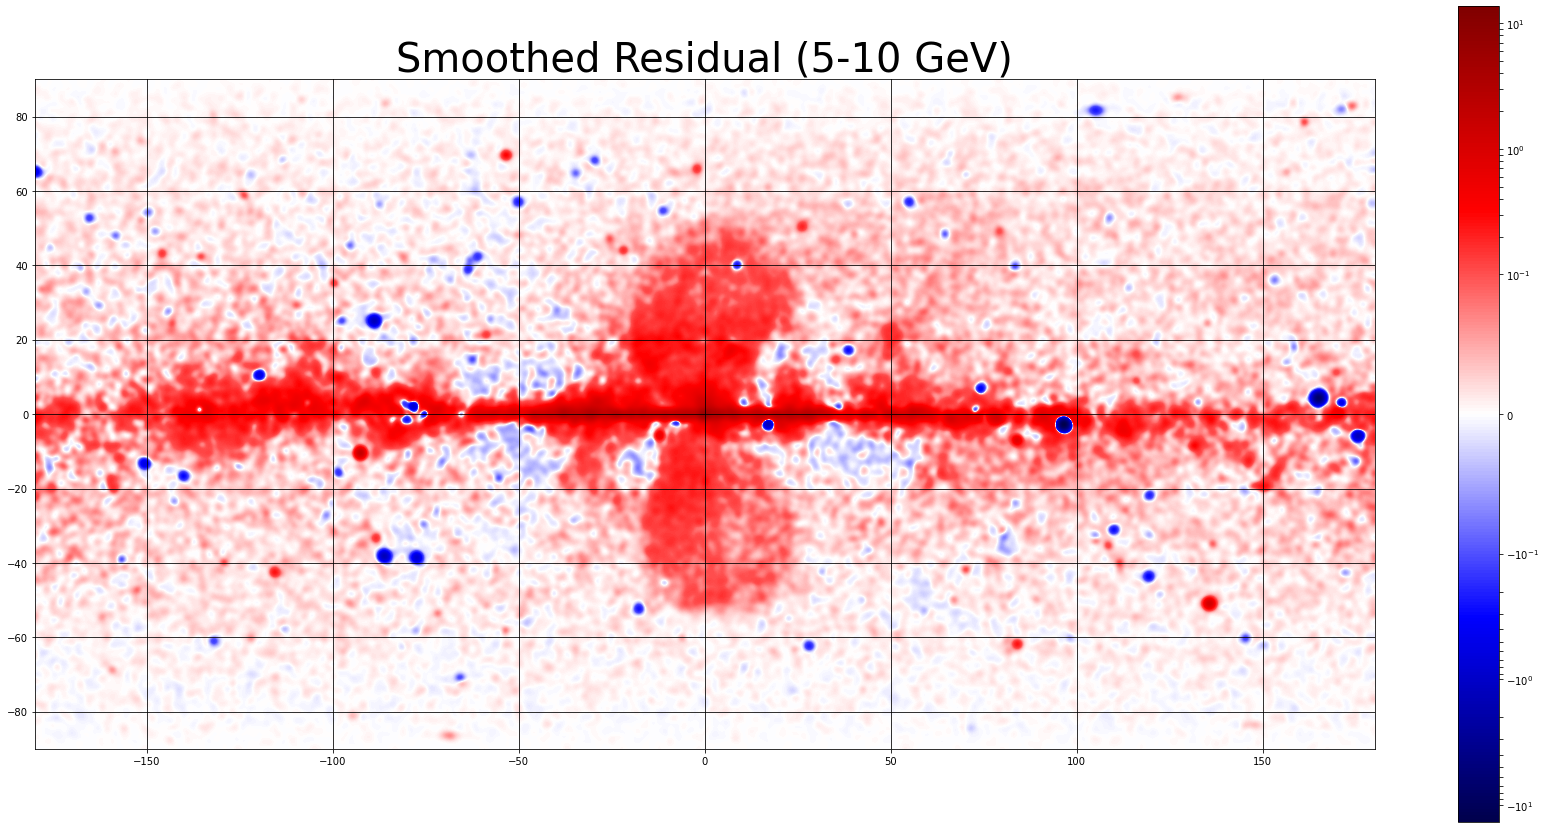

In [9]:
sigma = 8.45 # Sigma in pixels corresponding 2 degrees FWHM for 0.1 degree pixels
imshow_carree(gaussian_filter(v02_modified_results['5-10gev']['count_data'] - v02_modified_results['5-10gev']['total_model'], sigma), plt.cm.seismic, linthresh=1e-1, title='Smoothed Residual (5-10 GeV)')

Not surprsingly, this is an improvement, but still only amenable to coarse qualitative analysis. Below we show results from applying the TIPSH algorithm, which is described in the next section.

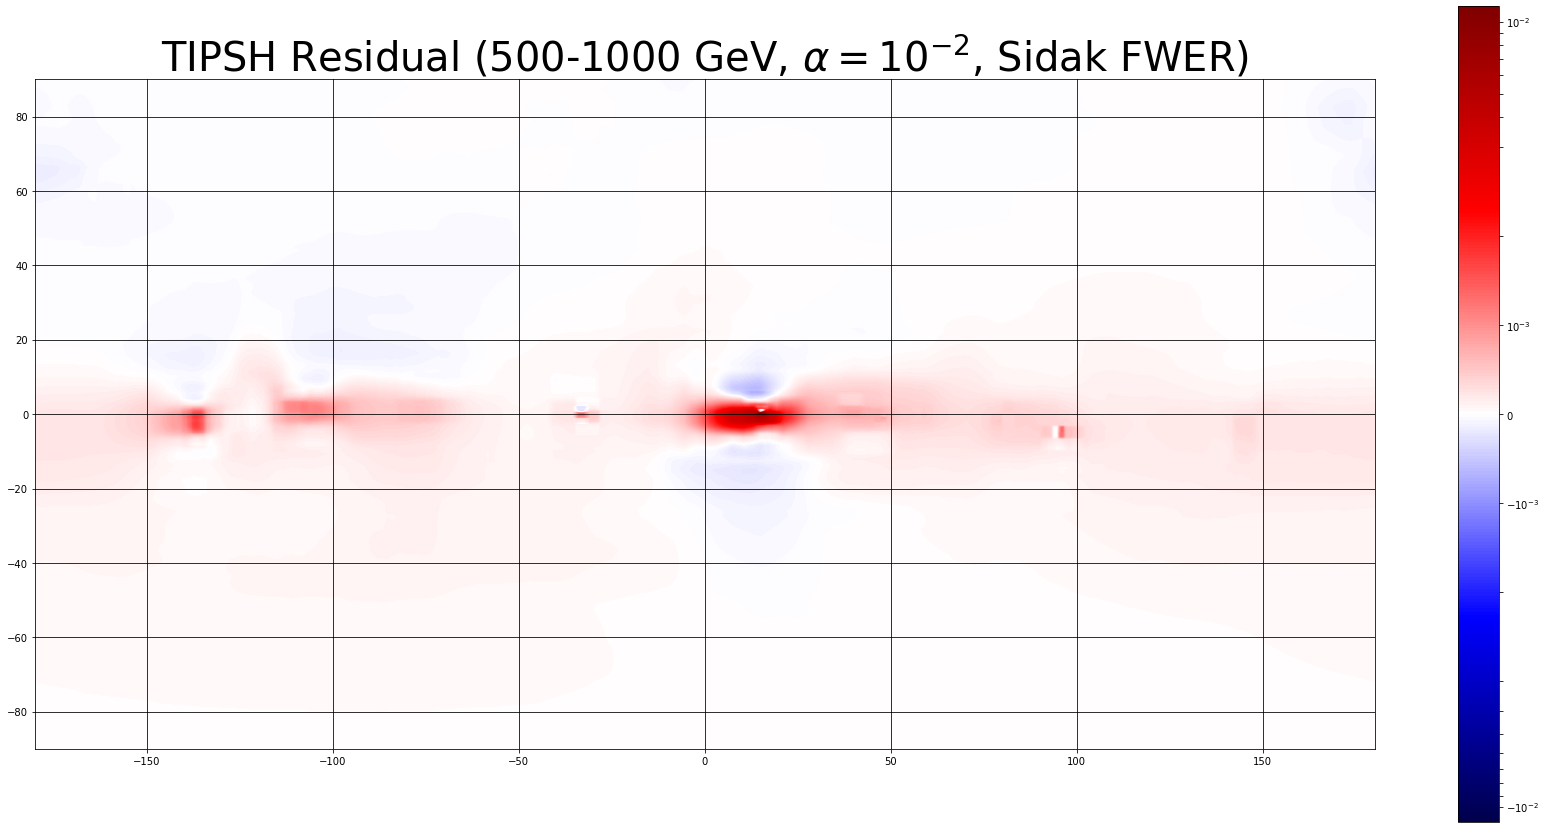

In [22]:
imshow_carree(v02_modified_results['500-1000gev']['count_rec'], plt.cm.seismic, linthresh=3e-3, title=r'TIPSH Residual (500-1000 GeV, $\alpha = 10^{-2}$, Sidak FWER)')

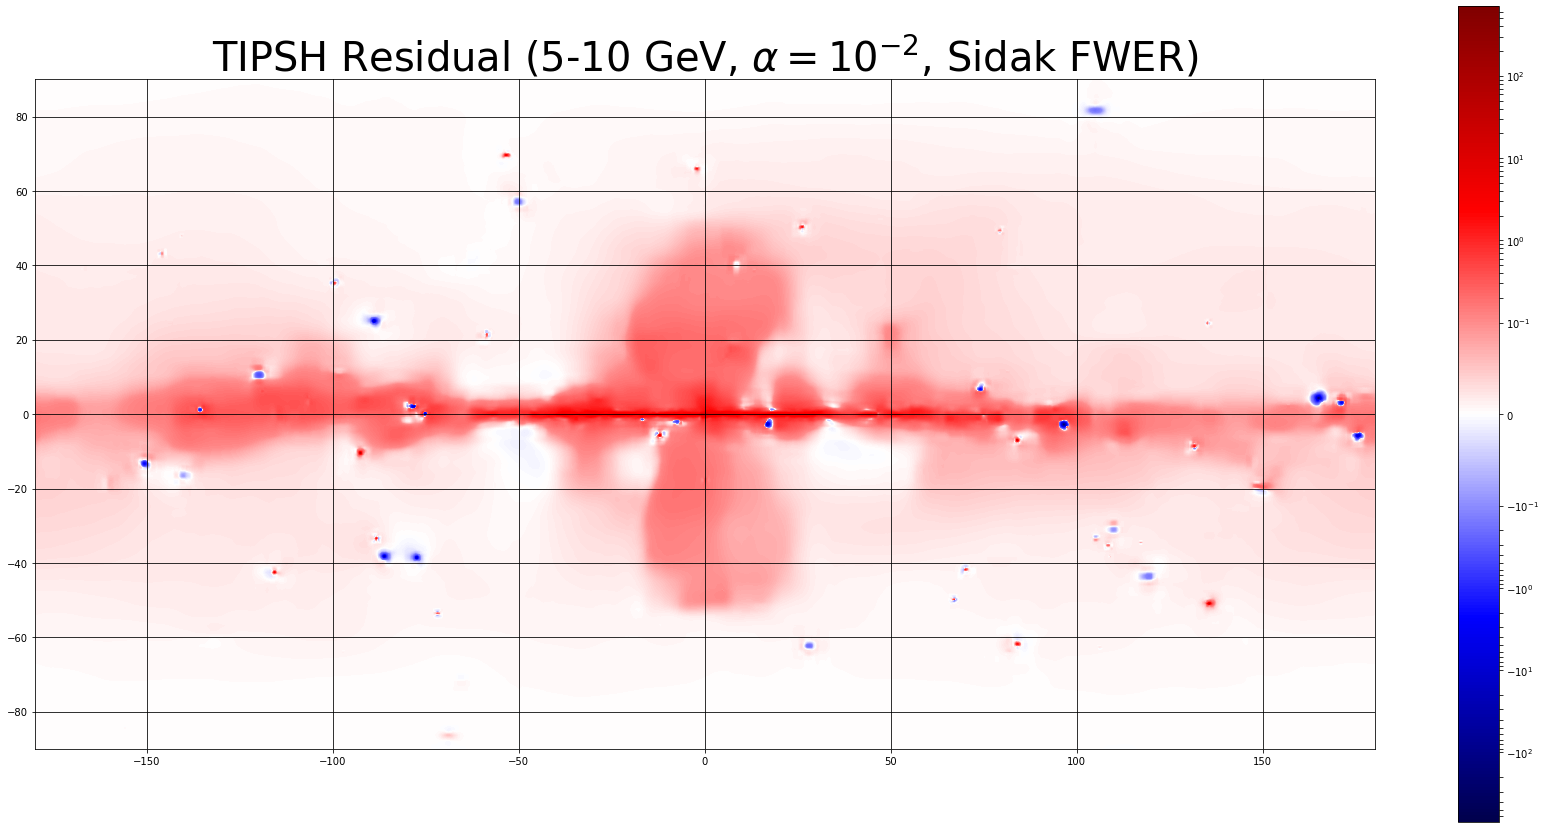

In [20]:
imshow_carree(v02_modified_results['5-10gev']['count_rec'], plt.cm.seismic, linthresh=1e-1, title=r'TIPSH Residual (5-10 GeV, $\alpha = 10^{-2}$, Sidak FWER)')

# TIPSH Algorithm

Are the TIPSH results above "better" than simple smoothing? To judge that question, we will need to understand the TIPSH algorithms, and fully examine its outputs. The acronym "TIPSH" stands for "Translationally Invariant Smoothing of Poisson data with Haar wavelets", and was described in (Kolaczyk and Dixon 1999). The Poisson data part should be clear: this algorithm is intended to work on signal or image data consisting of binned counts, where each bin/pixel rate is modeled as a Poisson variable. The "smoothing" is a little misleading in the context of this paper, and indicates that the algorithm, to some extent, can denoise a Poisson signal. There's some subtlety there which we will discuss further, and here note that we are less interested in denoising, more identifying where the data rejects the hypothesized count levels in the model, based on some statistical threshold (for pure denoising, see e.g. Hirakawa and Wolfe 2009).

"Translationally Invariant" and "Haar" refer to the specifics of how the wavelet transform is applied. Obviously we are using the Haar wavelet basis, applied in two dimensions. Example basis functions are given below.

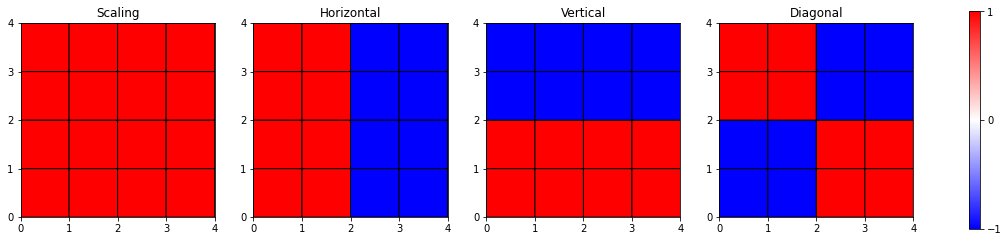

In [23]:
y, x = numpy.mgrid[0:5:1,0:5:1]
h = numpy.ones((4,4))
h[:, 2:4] = -1
v = numpy.ones((4,4))
v[2:4,:] = -1
d = numpy.ones((4,4))
d[0:2, 0:2] = -1
d[2:4, 2:4] = -1
s = numpy.ones((4,4))
wavelets = {'Scaling':s, 'Horizontal':h, 'Vertical':v, 'Diagonal':d}
fig, axs = plt.subplots(1,4, figsize=(20,4))
i = 0
for k in wavelets:
    ax = axs[i]
    c = ax.pcolor(x, y, wavelets[k], cmap=plt.cm.bwr, edgecolors='k', linewidths=1, norm=colors.Normalize(vmin=-1,vmax=1))
    ax.set_aspect('equal', 'box')
    ax.set_title(k)
    ax.xaxis.set_ticks(range(0,5))
    ax.yaxis.set_ticks(range(0,5))
    i += 1
fig.colorbar(c, ax=axs, ticks=[-1, 0, 1])

Haar wavelets come in exact powers of 2: $2x2$, $4x4$, ... , $4096x4096$, etc. Above we show a 4x4 case. The scaling function captures the average behavior over a $2^nx2^n$ region, while the horizontal, vertical, and diagonal wavelets capture changes at a particular size scale. Normally these functions would have some additional normalization such that the $L^2$ norm of the coefficents would equal that of the original image. We're intentionally leaving that out here, for reasons to be discussed later, and allow the wavelets to vary between $\pm 1$. The coefficients corresponding to the scaling or wavelet function is calculated by convolving with the target image. So in the example above, the scaling function coefficient would be simply the sum of the values of the $4x4$ set of pixels covered at a given location. The horizontal coeffcient would be the difference between adjacent $2x4$ blocks of pixels, and so forth. Coefficients would be computed for each power of 2 size scale, starting ant $2x2$ and proceeding up to the maximum size scale of interest, usually something like the entire image.

The usual fast wavelet transform (FWT) would transform $N$ pixels to $N$ wavelet coeffcients across multiple size scales using decimation. So it isn't a true convolution, instead we would do the first set of $2x2$ calculations starting at pixel $(0,0)$, then skip 2 to pixel $(2,0)$, then $(4,0)$ and so forth until we hit the end of the row, then jump up 2 rows to $(2,0)$, go to $(2,2)$, ... until we've covered the image. That would give us $N/4$ coefficients for the scaling function and each of the three wavelets at the 2-pixel size scale. Then the process is repeated, but now with the $\frac{N}{2}x\frac{N}{2}$ scaling function coefficients instead of the original pixels, giving $N/16$ scaling/wavelet coefficients for the 4-pixel scale. This continues until one hits the maximum size scale of interest.

The decimated FWT has the advantage of being very fast, $(O(N)$ for an image with $N$ pixels). But it should be clear that the exact values of the coefficients will change if you shift the image around. Looking at the horizontal wavelet above, for example, if there was a strong vertically-oriented edge in the underlying image, we would get a different value for the wavelet coefficient if that edge happened to fall at $x=2$ vs $x=3$. That in turn can lead to shift-sensitive artifacting when reconstructing an image where the wavelet coefficients have been shrunken or thresholded. The translationally invariant wavelet transform alleviates this issue at the expense of a little more computation and memory. An $N$ pixel image would lead to $N \log_2 N$ coefficients, where coefficients have been calculated for all non-redundant shifts of the image at each size scale.  This mitigates thresholding artifacts by effectively averaging over all image shifts, and also tends to smooth out the blockiness induced by the shape of the Haar wavelets.

That last sentence may prompt the question "Why choose Haar wavelets in the first place?" After all, one of the neat things about wavelets is their deep connections with functional analysis, and the ability to pick a wavelet basis which reflects the expected regularity characteristics of the function being analyzed. Haar would clearly not be the natural choice for astronomical images. We instead use Haar because, for Poisson image data, it facilitates quantitative statistical analysis. Consider the scaling function as we have defined it, without normalization. This is simply the sum over the individual Poisson variables for the relevant pixels. The sum of Poisson variables is itself a Poisson variable, so we have a known distribution for the scaling function coefficients. The wavelet coefficients are the difference between Poisson variables. The differencce in Poisson variables is distributed as the Skellam distribution. Having known distributions for the coefficients allows us to assess statistical "sameness" between related coefficients. For example, we can look the wavelet coefficient for a given position/scale from the count model, and the same size/scale for the data, and assess the probability that the data would have been observed if the model represented the "true" count level. For any other wavelet whose values take on values other than $\pm1$, we would have resort to computationally intensive Monte Carlo calculations to estimate this comparison.

So the motivation for TIPSH is hopefully clear. We use Haar wavelets to quantify the statistics of the wavelet coefficients derived from Poisson data, and the translationally invariant Haar transform to compensate for the less-than-ideal regularity of Haar wavelets for representing astronomical images. And rather than "smoothing" per se, we instead perform statistical comparison between the wavelet/scaling coefficients of the model and the data. In particular, we will calculate the p-value of the data coefficients given the Skellam (wavelet) or Poisson (scaling) distributions implied by the corresponding coefficients from the wavelet transform of the hypothesized counts map. The data coeffients with p-values less than some threshold (less likely( are considered to "reject" the model, and are kept as part of the "statistically significant residual", while data coefficients with p-values above the threshold (more likely) are set to zero. The TIPSH examples we showed above are reconstructed from the data coefficients thresholded in this manner, and could be considered as the statistically signficant difference between the data and model, where that signicance is measured in wavelet space rather than pixel space. See Appendix for details on how we handled boundary conditions for the wavelet transform as well as choice of false detection rate for thresholding.

# TIPSH Extras
We've shown a couple of examples reconstructing the statistically significant residual between a count model and observed data. This is the end product of TIPSH, providing an estimate of the residual counts, given a choice of false detection rates. Examination of intermediate productions from TIPSH can also be useful, name the map of p-values for wavelet coefficients, as well as the wavelet coefficients themselves. Below we show p-value maps. Play as a video to go through the different size scales, or manually explore with the slider. The intensity scale is the negative base-10 log of the p-value, so that coefficents with a higher chance of passing the threshold are brighter. The intensity is also clipped at 10 so the higher p-values (less likely, lower negative log) aren't completely washed out. P-values are shown for the vertical wavelets, so we can see how the Galactic plane structure is detected.

In [80]:
def pvalues(energy, d):
    return lambda j: -numpy.log10(tipsh.unspherify(tipsh.roll_sphere(v02_modified_results[energy][tipsh.level_key('pvalue', d, j+1)], 2**(j), 2**(j)))+1e-308)
def pvalue_scale_title(energy):
    return lambda j: r"$-\log_{{10}} p$, Scale ${r}^\circ \times {r}^\circ$ ({energy})".format(r=2**(j+1)/10, energy=energy)

In [ ]:
animate_carree(pvalues('500-1000gev', 'vs'), pvalue_scale_title('500-1000 GeV'), 12, plt.cm.viridis, norms=lambda j: colors.Normalize(vmin=0,vmax=10))

In [ ]:
animate_carree(pvalues('5-10gev', 'vs'), pvalue_scale_title('5-10 GeV'), 12, plt.cm.viridis, norms=lambda j: colors.Normalize(vmin=0,vmax=10))

Remember that each wavelet coefficient can be modelled as a Skellam variable, the difference of two Poisson variables, given the hypothetical count map. So the p-values plotted above are the probability that one would see a value greater than or equal to that of the corresponding data coefficient, or less than or equal to data coefficient, depending on which side of the model Skellam distribution the data coefficient falls. So the brightest yellow parts of the plot have at p-value of at most $10^{-10}$, those in the brighter green around $10^{-8}$, and so forth. In otherwords, the brightest yellow areas have a chance of at most $1:10^{10}$ of being a false detection due to noise. The chance of false detection is thus directly quantifiable for the wavelet coefficients, and given that wavelets are localized in both location and frequency, the p-values give a powerful tool to quantitatively assess the detection significance of features seen in the reconstructed image. The p-value thresholds used to reconstruct the examples above and in the rest of this notebook vary based on the number of independent tests, using the Sidak procedure [REFERENCE] for controlling the family-wise error rate (FWER). We discuss this further in the appendix, and note here that we have chosen the FWER $\alpha = 10^{-2}$, which implies that the p-value threshold (i.e. coefficient-wise false detection rate) is given by one half of $\alpha_j$ (half for each tail of the distribution), where $\alpha_j = 1 - (1 - \alpha)^{1/2^{2(J - j)}}$, $j$ is the wavelet resolution level (e.g. size scale $2^j \times 2^j$), and $J = \log_2 N$, where $N$ is the total number of pixels supplied to the wavelet transform ($4096 \times 4096$ in this case, see Appendix for details). $2^{2(J - j)}$ represents the number of statistically independent tests at wavelet level $j$ for a given image shift. For a given translation of the image, the wavelet coefficients are statistically independent. They are not so across shifts, as discussed in more detail in (Kolaczyk and Dixon 1999).

We can also examine the wavelet coefficients themselves; or more interestingly, the reconstructed images using each resolution level. The total residual images above are the sum of the level-wise reconstructions below, plus a constant offset from the scaling coefficient at the largest size scale (in this case, just the average counts in either the model or data, depending on the p-value thresholding). Again, this gives a picture of the significant features detected at different size scales, combining the linear filter from the wavelets with the nonlinear statistical thresholding based on Skellam p-values.

In [71]:
def level_recs(energy):
    return lambda j: v02_modified_results[energy][tipsh.level_key('level_recs', j+1)]
def level_recs_scale_title(energy):
    return lambda j: r"Reconstructed image, Scale ${r}^\circ \times {r}^\circ$ ({energy})".format(r = 2**(j+1)/10, energy=energy)

In [72]:
animate_carree(level_recs('500-1000gev'), level_recs_scale_title('500-1000 GeV'), 12, plt.cm.seismic, linthresh=lambda j: 1e-3/(j+1))

In [73]:
animate_carree(level_recs('5-10gev'), level_recs_scale_title('5-10 GeV'), 12, plt.cm.seismic, linthresh=lambda j: 1e-1/(j+1))

# Results
## v02 Galactic Diffuse Model and Fermi Bubbles
We begin by showing results using the v02 version of the Galactic diffuse emission model available from FSSC [LINK].The data were selected and prepared as described [here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/LAT_weekly_allsky.html). Specifically, a zenith cut of 90 degrees was applied across all energies, and we selected the `P8R3_SOURCE_V3` instrument response function, including both front and back converting events. The various model components (point sources, diffuse sources, Galactic diffuse, isotropic diffuse) were generated via the `gtmodel` and `gtsrcmap` tools. The `gll_iem_v02.fit` was provided as input for the Galactic diffuse model. Some caveats:
* The FSSC site warns against using `P8R3_SOURCE_V3` for analyzing extended emission. For the results we're discussing here, mostly focusing on the statistics and morphology of the Fermi bubbles, this probably isn't an issue. The specific features of interest we discuss here are local and specific to the Fermi bubbles, and seem unlikely to change with different data cuts. That said, the TIPSH software is available [LINK] and further analyses with different cuts or models would certainly be interesting.
* Similar cautions are given FSSC about using the v02 model with later data and IRFs. Again, this isn't a concern here. We need to use the v02 model as v07 includes a model of the Fermi bubbles, so they're more or less subtracted away and can't be seen in the residuals (though as we'll see, this is not generally true, and the model probably needs further refinement). We will also present results based on the v07 model later in this notebook.
* The data here are projected and binned as Plate Carree rather than using the HEALPIX scheme employed in other papers performing all-sky analysis of Fermi data. This is to facilitate the use of the Haar wavelet transform, which assumes a rectilinear pixel grid. The downside is that pixels are not equal area, hence there will be a definite effect where higher latitudes will have less counts per pixel on average. This is mitigated to some extent by the multiresolution nature of TIPSH.
* The "out of the box" normalizations of the diffuse models, particularly the Galactic mode, are known the be wrong. The Galactic model in particular is overestimated by the FSSC tools, probably due to the influence of unresolved high-energy sources in the Galactic plane.  This matters less for likelihood analysis over a limited FOV, since the intensity of all components are adjusted in the fit, and the small FOV limits systematic errors due to variations in the models of extended emission. Here we will give results both for the models as given and scaled by hand to at least appear more sensible, e.g. not massively over-subtracting the Galactic plane. This is admittedly subjective, but we are not using these results to draw detailed physical conclusions, simply presenting the differences and associated statistics given some hypothesis.
* A general caveat using TIPSH (or any method based on differencing data and model): it will be tempting to place physical interpretation on the results. But remember that these are differences between a hypothesis and the data, and "features" may not actually represent independent physical phenomena. Instead, TIPSH residuals should be used to generate physically-motivated hypotheses, which can then be used to generate updated hypothetical count maps, which in turn can be verified against the data using TIPSH.